In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
decision_data = pd.read_csv('Carp Manning with Attributes.csv')

# We only need some of this data
judge_decisions = decision_data[['Authoring Judge','Court Location','Number of Judges','Circuit','Year','Decision Ideology',
                                'Case Type','Case Category','Year of Appointment','Appointing President','Judge Party',
                                'Gender','Race','Year of Birth','ABA Rating','Congress','Unity']].copy()

# We begin by converting the decision ideology, which is either liberal or conservative, into a dummy.
def libcon_dummy(ideology):
    if ideology == 'Conservative':
        return 100
    if ideology == 'Liberal':
        return -100
    else:
        return np.nan
judge_decisions['Decision Ideology'] = judge_decisions['Decision Ideology'].apply(libcon_dummy)

# Here is what the data looks like
judge_decisions.head()

,Authoring Judge,Court Location,Number of Judges,Circuit,Year,Decision Ideology,Case Type,Case Category,Year of Appointment,Appointing President,Judge Party,Gender,Race,Year of Birth,ABA Rating,Congress,Unity
0,"Avis, John Boyd","Camden, NJ",1,3RD CIRCUIT,1932,100,alien petitions,Civil Liberties/Rights Cases,1929,HOOVER,Republican,male,white/caucasian,1875.0,Not Rated,78TH,Unified
1,"Avis, John Boyd","Camden, NJ",1,3RD CIRCUIT,1932,100,alien petitions,Civil Liberties/Rights Cases,1929,HOOVER,Republican,male,white/caucasian,1875.0,Not Rated,78TH,Unified
2,"Strum, Louie W.","Jacksonville, FL",1,5TH CIRCUIT,1932,100,(non)conv-criminal case,Criminal Justice Cases,1931,HOOVER,Democrat,male,white/caucasian,1890.0,Not Rated,81ST,"Divided, House"
3,"Moscowitz, Grover","Brooklyn, NY",5,2ND CIRCUIT,1932,100,criminal court motions,Criminal Justice Cases,1925,COOLIDGE,Republican,male,white/caucasian,1886.0,Not Rated,80TH,Unified
4,"Cochran, Andrew","Maysville, KY",1,6TH CIRCUIT,1932,-100,voting rights,Civil Liberties/Rights Cases,1901,MCKINLEY,Republican,male,white/caucasian,1854.0,Not Rated,73RD,Unified


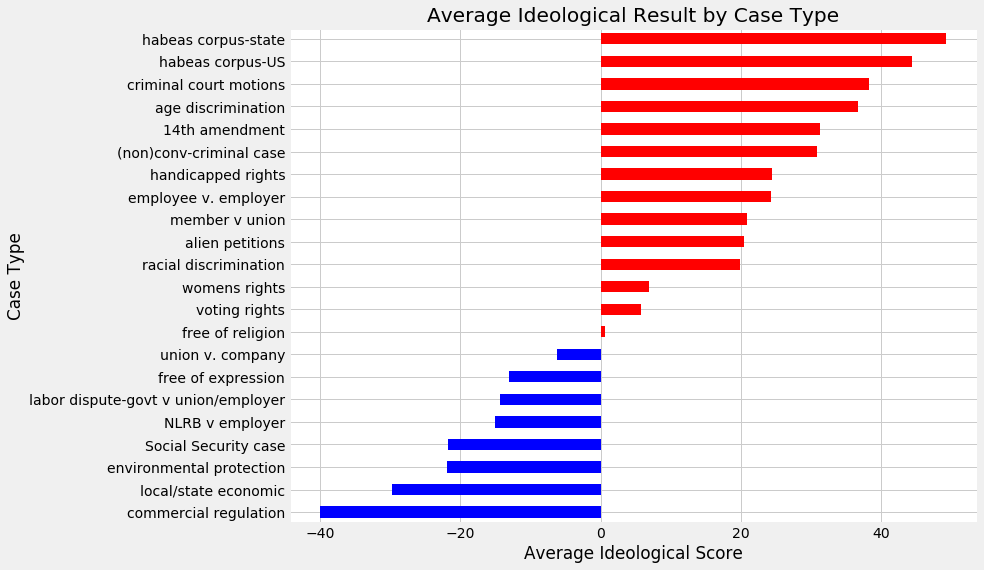

In [3]:
# Get the list of case types with more than 1000 cases
high_vol_types = judge_decisions[['Case Type','Authoring Judge']].groupby('Case Type').count().reset_index()
high_vol_types['High Vol'] = [1 if count >= 1000 else 0 for count in high_vol_types['Authoring Judge']]
high_vol_types = high_vol_types[high_vol_types['High Vol'] == 1]
high_vol_types = high_vol_types.drop(columns = ['Authoring Judge','High Vol'])

ideology_by_type = (judge_decisions[['Case Type','Decision Ideology']].groupby('Case Type')
                    .mean().sort_values('Decision Ideology').reset_index())
ideology_by_type = ideology_by_type.merge(high_vol_types, on = 'Case Type', how = 'right')

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ax.set_title("Average Ideological Result by Case Type")
ax.set_xlabel("Average Ideological Score")
colors = ["b" if x < 0 else "r" for x in ideology_by_type['Decision Ideology'].values]

ideology_by_type.plot(kind = 'barh', x = 'Case Type', y = 'Decision Ideology', ax = ax, color = colors, legend = False)

In [4]:
ideology_by_party_year = (judge_decisions[['Year','Judge Party','Decision Ideology']].groupby(['Year','Judge Party',])
                          .mean().reset_index())
ideology_by_party_year = ideology_by_party_year[(ideology_by_party_year['Judge Party'] == 'Democrat') |
                                                (ideology_by_party_year['Judge Party'] == 'Republican')]
# 1931 is first year where both parties are present
ideology_by_party_year = ideology_by_party_year[ideology_by_party_year['Year'] >= 1933]
ideology_by_party_year.sample(10)

,Year,Judge Party,Decision Ideology
42,1944,Democrat,1.477833
94,1959,Democrat,20.000000
37,1942,Republican,20.720721
225,1995,Republican,32.613391
132,1968,Republican,28.607595
195,1985,Republican,14.503817
106,1962,Democrat,13.239437
204,1988,Republican,18.427948
34,1941,Republican,9.909910
239,2000,Democrat,6.109980


Text(0, 0.5, 'Mean Decision Ideology Score')

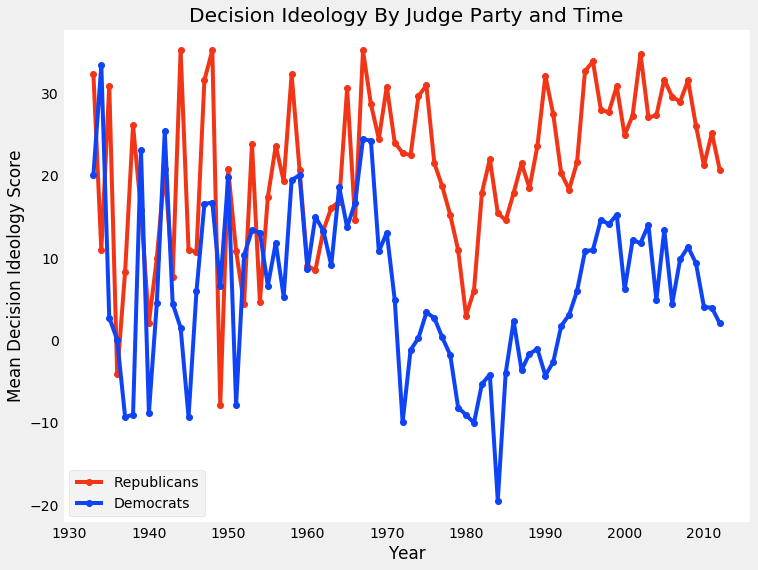

In [5]:
democrats = ideology_by_party_year["Judge Party"] == "Democrat"
republicans = ideology_by_party_year["Judge Party"] == "Republican"

fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)

ax.plot(ideology_by_party_year[republicans]["Year"],
        ideology_by_party_year[republicans]["Decision Ideology"],"-o",label="Republicans",color="#f23417")

ax.plot(ideology_by_party_year[democrats]["Year"],
        ideology_by_party_year[democrats]["Decision Ideology"],"-o",label="Democrats",color="#0e44f5")

ax.legend()
ax.set_title("Decision Ideology By Judge Party and Time")
ax.set_xlabel("Year")
ax.set_ylabel("Mean Decision Ideology Score")

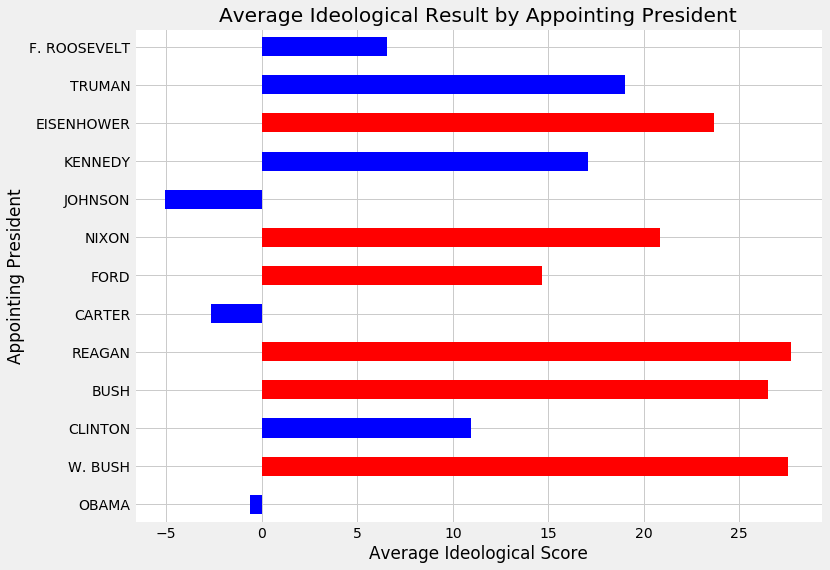

In [6]:
ideology_by_app_pres = (judge_decisions[judge_decisions['Year of Appointment']>=1933]
                        [['Appointing President','Decision Ideology']]
                        .groupby(['Appointing President'])
                        .mean().reset_index().reindex([9,12,2,0,10,1,5,8,6,7,3,11,4]))
fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ax.set_title("Average Ideological Result by Appointing President")
ax.set_xlabel("Average Ideological Score")
colors = ["b" if x in ['F. ROOSEVELT','TRUMAN','KENNEDY','JOHNSON','CARTER','CLINTON','OBAMA'] 
          else "r" for x in ideology_by_app_pres['Appointing President'].values]

ideology_by_app_pres.plot(kind = 'barh', x = 'Appointing President', y = 'Decision Ideology',
                          ax = ax, color = colors, legend = False)

In [7]:
ideology_by_gen_race = (judge_decisions[judge_decisions['Race'].isin(
                                        ['African-American/black','Asian-American','Latino/Hispanic','white/caucasian'])]
                        [['Gender','Race','Decision Ideology']])
ideology_by_gen_race.pivot_table(index='Race', columns='Gender', values='Decision Ideology', margins=True)

Gender,female,male,All
Race,,,
African-American/black,1.870748,5.016212,4.439944
Asian-American,-14.754098,5.413105,0.211416
Latino/Hispanic,5.091650,26.355388,24.271457
white/caucasian,12.628256,15.822735,15.497959
All,10.976939,15.695166,15.190996
